### IMPORT LIBRARIES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import skimage.io
import tensorflow 
import os
import glob
import tqdm

from tqdm import tqdm 

from skimage.io import imread, imshow
from skimage.transform import resize

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

%matplotlib inline 


Bad key "text.kerning_factor" on line 4 in
C:\Users\Mrida\anaconda3\envs\tp\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


### IMPORT / VIEWING / PREPROCESSING DATASET

In [2]:
# Training Data

alluvial_soil = os.listdir('Soil_Dataset/Train/Alluvial_Soil/')
black_soil    = os.listdir('Soil_Dataset/Train/Black_Soil/')
clay_soil     = os.listdir('Soil_Dataset/Train/Clay_Soil/')
red_soil      = os.listdir('Soil_Dataset/Train/Red_Soil/')

In [3]:
a, b, c, d = len(alluvial_soil), len(black_soil), len(clay_soil), len(red_soil)
e = a + b + c + d
print("Total images: ", e)

Total images:  715


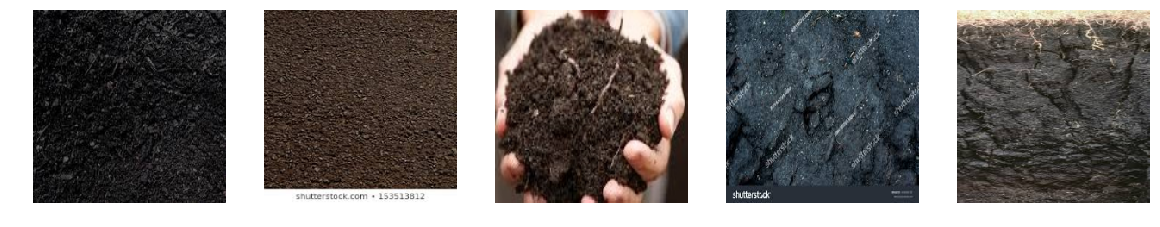

In [4]:
# Viewing - Black Soil 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))
for i in range(0,5):
    rand = np.random.randint(len(black_soil)) 
    img  = imread('Soil_Dataset/Train/Black_Soil/' + black_soil[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

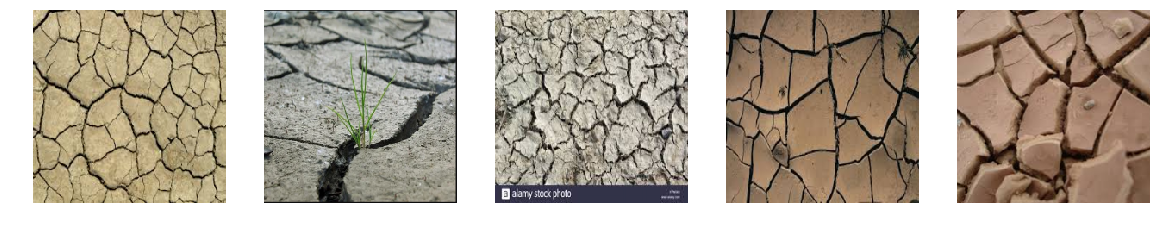

In [5]:
# Viewing - Clay Soil 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))
for i in range(0,5):
    rand = np.random.randint(len(clay_soil)) 
    img  = imread('Soil_Dataset/Train/Clay_Soil/' + clay_soil[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

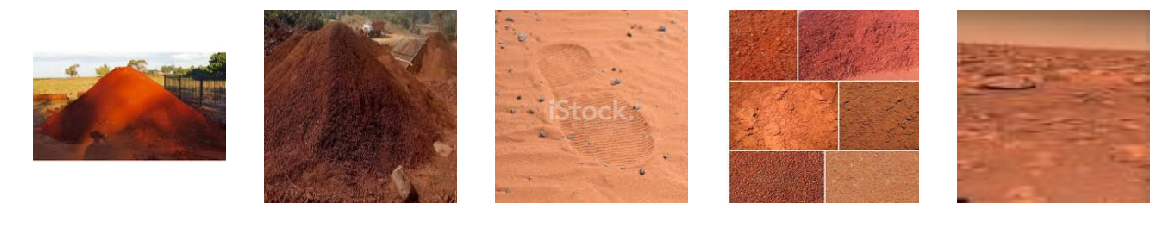

In [6]:
# Viewing - Red Soil 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))
for i in range(0,5):
    rand = np.random.randint(len(red_soil)) 
    img  = imread('Soil_Dataset/Train/Red_Soil/' + red_soil[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

**`DATA AUGMENTATION`**

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=30,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range=0.2,
                                   shear_range=0.2,
                                   fill_mode='nearest')

test_datagen  = ImageDataGenerator(rescale=1./255)

In [8]:
train_dataset = train_datagen.flow_from_directory(directory = 'Soil_Dataset/Train',
                                                  target_size = (224,224),
                                                  class_mode = 'categorical',
                                                  batch_size = 64)

Found 715 images belonging to 4 classes.


In [9]:
test_datset = test_datagen.flow_from_directory(directory = 'Soil_Dataset/Test',
                                               target_size = (224,224),
                                               class_mode = 'categorical',
                                               batch_size = 64)

Found 188 images belonging to 4 classes.


### MODEL BUILDING 

> `MODEL INITIALIZATION`

In [10]:
model = Sequential()

> `BUILDING LAYERS`

In [11]:
# Input Layer 
model.add(InputLayer(input_shape = (224,224,3)))


# Layers
model.add(Conv2D(filters = 32,  kernel_size  = (3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64,  kernel_size  = (3, 3), strides=(1, 1), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.25))


# Flatten()
model.add(Flatten())


# Full Connected Layer 
model.add(Dense(units = 128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))


# Output layer 
model.add(Dense(units = 4, activation = 'softmax'))

> `MODEL SUMMARY`

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 222, 222, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 109, 109, 64)      256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0

> `MODEL COMPILE`

In [13]:
model.compile(optimizer = tensorflow.keras.optimizers.Adam(1e-5), loss = 'categorical_crossentropy', metrics = ['accuracy'])

> `DEFINING CALLBACKS`

In [14]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 10)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

learning_rate = ReduceLROnPlateau(monitor = 'val_accuracy',
                                  mode = 'max',
                                  verbose = 1,
                                  factor = 0.1,
                                  min_delta = 1e-5,
                                  patience = 3)

callback_list = [earlystopping, checkpoint, learning_rate]

> `MODEL RUNNING`

In [15]:

model_history = model.fit(train_dataset,
                          validation_data = test_datset,
                          epochs = 500,
                          verbose = 1,
                          callbacks = callback_list)

model.save('soil_model'+ '.h5')


Train for 12 steps, validate for 3 steps
Epoch 1/500
11/12 [==========================>...] - ETA: 4s - loss: 0.7498 - accuracy: 0.7235
Epoch 00001: val_accuracy improved from -inf to 0.25532, saving model to ./best_weights.hdf5
12/12 [==============================] - 58s 5s/step - loss: 0.7319 - accuracy: 0.7301 - val_loss: 1.4199 - val_accuracy: 0.2553
Epoch 2/500
11/12 [==========================>...] - ETA: 5s - loss: 0.4023 - accuracy: 0.8409 
Epoch 00002: val_accuracy did not improve from 0.25532
12/12 [==============================] - 59s 5s/step - loss: 0.3915 - accuracy: 0.8406 - val_loss: 1.6328 - val_accuracy: 0.2553
Epoch 3/500
11/12 [==========================>...] - ETA: 4s - loss: 0.3613 - accuracy: 0.8479
Epoch 00003: val_accuracy did not improve from 0.25532
12/12 [==============================] - 61s 5s/step - loss: 0.3666 - accuracy: 0.8531 - val_loss: 1.7755 - val_accuracy: 0.2553
Epoch 4/500
11/12 [==========================>...] - ETA: 5s - loss: 0.3489 - accur